In [258]:
import torch
import torch.nn as nn
import torch.optim import SGD, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"

In [402]:
transform = transforms.ToTensor()
data_path = '../data/cifar/' # This can be any directory you want 
# to download cifar to

Files already downloaded and verified
Files already downloaded and verified


In [461]:
class Cifar10_Dataset(Dataset):
    def __init__(self, x, y):
        x = torch.tensor(x).float()/255  #Input data scailing
        x = x.reshape(-1, 3 * 32 * 32)
        y = torch.tensor(y).long()
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

def get_model():
    model = nn.Sequential(
        nn.Linear(3 * 32 * 32, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84,10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3) #learning rate : 0.001
    return model, loss_fn, optimizer
  
def train_batch(x, y, model, opt, loss_fn):
    model.train() 
    prediction = model(x)
    # compute loss
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()
  
def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
      prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = (argmaxes == y)
    return is_correct.cpu().numpy().tolist()
  
@torch.no_grad()
def val_loss(x, y, model):
  prediction = model(x)
  val_loss = loss_fn(prediction, y)
  return val_loss.item()

In [ ]:
cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
tr_images = cifar10_train.data
tr_targets = cifar10_train.targets
val_images = cifar10_val.data
val_targets = cifar10_val.targets

In [462]:
def get_data():
  train = Cifar10_Dataset(tr_images, tr_targets)
  train_loader = DataLoader(train, batch_size=100, shuffle=True)
  validation = Cifar10_Dataset(val_images, val_targets)
  val_loader = DataLoader(validation, batch_size=10000, shuffle=False)
  return train_loader, val_loader

train_loader, val_loader = get_data()

In [468]:
model, loss_fn, optimizer = get_model()
model = model.to(device)
num_epochs=10
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
#learning rate annealing
for epoch in range(num_epochs):
    train_epoch_losses, train_epoch_accuracies = [], []
    # train loss
    for ix, batch in enumerate(iter(train_loader)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    # train accuracy
    for ix, batch in enumerate(iter(train_loader)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    # valid loss
    for ix, batch in enumerate(iter(val_loader)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y ,model)
    val_epoch_accuracy = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4
5
6
7
8
9


In [469]:
W = model.state_dict()
print(W)

OrderedDict([('0.weight', tensor([[-0.0179, -0.0078,  0.0119,  ..., -0.0009,  0.0135, -0.0129],
        [-0.0016, -0.0160,  0.0223,  ..., -0.0199, -0.0096,  0.0036],
        [-0.0863, -0.0322,  0.0006,  ...,  0.1152,  0.0952, -0.1063],
        ...,
        [ 0.0036, -0.0076,  0.0078,  ...,  0.0059, -0.0035, -0.0110],
        [ 0.0014,  0.0194,  0.0165,  ..., -0.0017, -0.0185, -0.0217],
        [ 0.0426,  0.0565,  0.1925,  ..., -0.0501, -0.1211, -0.0712]])), ('0.bias', tensor([-1.1970e-02, -2.1328e-02,  3.2552e-01,  3.3629e-03, -1.5115e-02,
        -9.8406e-02, -2.9642e-01, -7.4802e-03,  7.5710e-03,  8.2002e-03,
        -1.9015e-02, -1.6298e-02, -1.2685e-02, -2.4389e-01, -1.5944e-02,
         6.5216e-03,  9.6262e-03, -2.5680e-03,  9.5738e-03,  1.3505e-02,
         3.0476e-03, -4.2807e-01,  2.4192e-03, -3.7533e-03, -1.2491e-01,
        -3.2052e-03,  7.9202e-03,  1.7350e-02,  3.3391e-03, -1.4949e-02,
        -7.3961e-03,  5.1168e-02, -1.8333e-02, -6.1122e-03, -1.6870e-02,
        -2.7661e

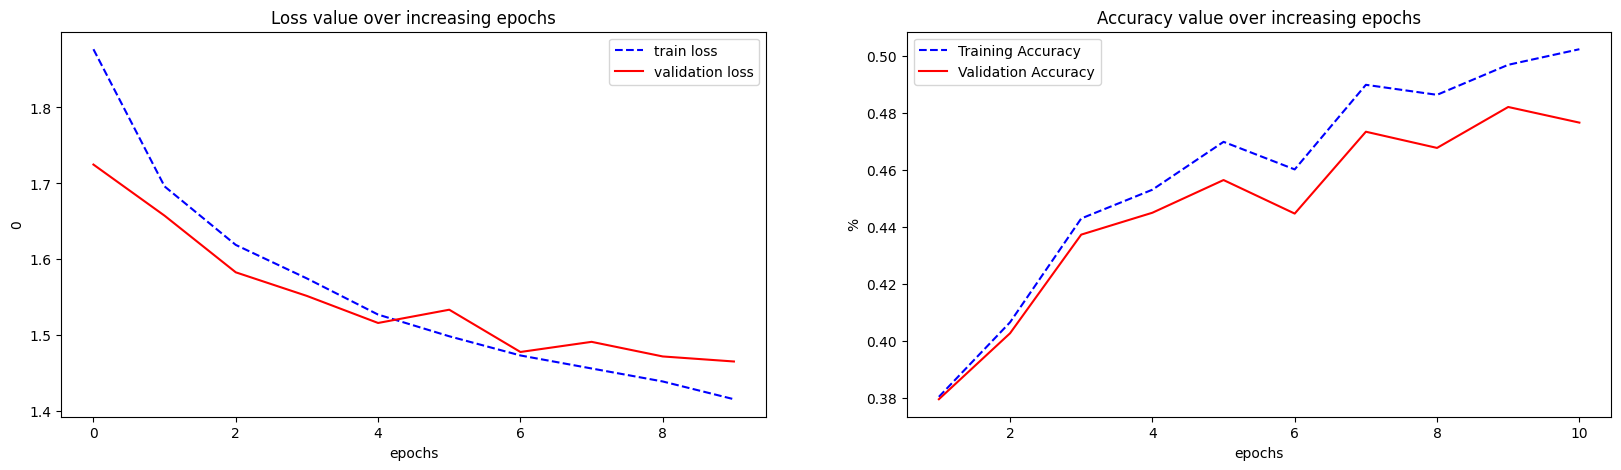

In [470]:
# Get Graph
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
num_epochs = 10
plt_epochs = np.arange(num_epochs)+1
fig, axs = plt.subplots(2, 1)
# Loss
axs[0].plot(plt_epochs, train_losses, linestyle='--', color='b', label='Training loss')
axs[0].plot(plt_epochs, val_losses, color='r', label='Validation loss')
axs[0].xaxis.set_major_locator(mtick.MultipleLocator(10))
axs[0].set_title('Loss value over increasing epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
# axs[0].set_ylim(bottom=0)

# Accuracy
axs[1].plot(plt_epochs, train_accuracies, linestyle='--', color='b', label='Training accuracy')
axs[1].plot(plt_epochs, val_accuracies, color='r', label='Validation accuracy')
axs[1].xaxis.set_major_locator(mtick.MultipleLocator(10))
axs[1].set_title('Accuracy value over increasing epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy(%)')
axs[1].legend()

plt.tight_layout()
plt.show()